<a href="https://colab.research.google.com/github/Tomokki/private_Python-.gitkeep/blob/main/tutorial_nishika_56_mansion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

不動産価格予測

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install optuna japanize-matplotlib > /dev/null

In [ ]:
# ご自身のパスを設定
YOUR_PATH = "/content/drive/MyDrive/cpt-house-2024wi"

In [ ]:
cd {YOUR_PATH}

/content/drive/MyDrive/cpt-house-2024wi


In [ ]:
import re

import japanize_matplotlib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
sns.set(font="IPAexGothic")

from glob import glob
from functools import partial
from itertools import product
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, OrdinalEncoder

## 実行環境の情報

dataディレクトリ配下に以下のようにデータを格納しているとする

├─ input<br>
│   ├─ data_explanation.xlsx<br>
│   ├─ sample_submission.csv<br>
│   ├─ test.csv<br>
│   └─ train<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├─ 01.csv<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├─ 02.csv<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├─ 03.csv<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├─ ...<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└─ 47.csv<br>
└─ output


メモリサイズ(GB)

In [ ]:
!cat /proc/meminfo | awk '($1=="MemTotal:") {print $2/1048576}'

12.6783


Pythonバージョン

In [ ]:
!python -V

Python 3.10.12


Pythonライブラリ情報

In [ ]:
!pip freeze

absl-py==1.4.0
aiohttp==3.8.6
aiosignal==1.3.1
alabaster==0.7.13
albumentations==1.3.1
alembic==1.12.1
altair==4.2.2
anyio==3.7.1
appdirs==1.4.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array-record==0.5.0
arviz==0.15.1
astropy==5.3.4
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.0
attrs==23.1.0
audioread==3.0.1
autograd==1.6.2
Babel==2.13.1
backcall==0.2.0
beautifulsoup4==4.11.2
bidict==0.22.1
bigframes==0.13.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.3.1
bqplot==0.12.42
branca==0.7.0
build==1.0.3
CacheControl==0.13.1
cachetools==5.3.2
catalogue==2.0.10
certifi==2023.7.22
cffi==1.16.0
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.7
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpickle==2.2.1
cmake==3.27.7
cmdstanpy==1.2.0
colorcet==3.0.1
colorlog==6.7.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.3
cons==0.4.6
contextlib2==21.6.0
contourpy==1.2.0
cryptography==41.0.5
cufflinks==0.17.3
cupy-cuda11x==11.0.0
cvxopt==1.3.

## 前処理

In [ ]:
def normalize_moyori(moyori):
    if moyori == moyori:
        if moyori == '30分?60分':
            moyori = 45
        elif moyori == '1H?1H30':
            moyori = 75
        elif moyori == '1H30?2H':
            moyori = 105
        elif moyori == '2H?':
            moyori = 120
        moyori = int(float(moyori))
    return moyori

In [ ]:
def normalize_area(area):
    if area == area:
        area = int(re.sub('m\^2未満|㎡以上', '', str(area)))
    return area

In [ ]:
def convert_wareki_to_seireki(wareki):
    if wareki == wareki:
        if wareki == '戦前':
            wareki = '昭和20年'
        value = wareki[2:-1]
        if value == '元':
            value = 1
        else:
            value = int(value)
        if '昭和' in wareki:
            seireki = 1925+value
        elif '平成' in wareki:
            seireki = 1988+value
        elif '令和' in wareki:
            seireki = 2018+value
    else:
        seireki = wareki
    return seireki

In [ ]:
BASE_PATH = './data/'

In [ ]:
paths = glob(BASE_PATH + 'input/train/*')
train_dfs = []
for path in paths:
    train_df = pd.read_csv(path)
    train_dfs.append(train_df)
train_df = pd.concat(train_dfs)
train_df.reset_index(drop=True, inplace=True)
test_df = pd.read_csv(BASE_PATH + 'input/test.csv')

<ipython-input-13-a59eff511f2d>:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(path)
<ipython-input-13-a59eff511f2d>:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(path)
<ipython-input-13-a59eff511f2d>:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(path)
<ipython-input-13-a59eff511f2d>:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(path)


In [ ]:
train_df.isnull().sum()

ID                   0
種類                   0
地域              806996
市区町村コード              0
都道府県名                0
市区町村名                0
地区名                678
最寄駅：名称            2827
最寄駅：距離（分）        23253
間取り              30949
面積（㎡）                0
土地の形状           806996
間口              806996
延床面積（㎡）         806996
建築年              23615
建物の構造            23757
用途               92592
今後の利用目的         369083
前面道路：方位         806996
前面道路：種類         806996
前面道路：幅員（ｍ）      806996
都市計画             21128
建ぺい率（％）          25915
容積率（％）           25915
取引時点                 0
改装               80914
取引の事情等          787414
取引価格（総額）_log         0
dtype: int64

In [ ]:
sub_df = pd.read_csv(BASE_PATH + 'input/sample_submission.csv')

In [ ]:
ID = 'ID'
TARGET = '取引価格（総額）_log'
rm_cols = []

In [ ]:
df = pd.concat([train_df, test_df])

rm_cols += ['市区町村コード']
for i,v in df.nunique().iteritems():
    if v <= 1:
        rm_cols.append(i)

rm_cols

<ipython-input-17-2a31c2b9037f>:4: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i,v in df.nunique().iteritems():


['市区町村コード',
 '種類',
 '地域',
 '土地の形状',
 '間口',
 '延床面積（㎡）',
 '前面道路：方位',
 '前面道路：種類',
 '前面道路：幅員（ｍ）']

In [ ]:
test_df[TARGET] = np.nan
train_df.drop(rm_cols, axis=1, inplace=True)
test_df.drop(rm_cols, axis=1, inplace=True)
df = pd.concat([train_df, test_df])
df.sort_values('取引時点', inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(826117, 19)

In [ ]:
df['取引時点'].unique()

array(['2005年第3四半期', '2005年第4四半期', '2006年第1四半期', '2006年第2四半期',
       '2006年第3四半期', '2006年第4四半期', '2007年第1四半期', '2007年第2四半期',
       '2007年第3四半期', '2007年第4四半期', '2008年第1四半期', '2008年第2四半期',
       '2008年第3四半期', '2008年第4四半期', '2009年第1四半期', '2009年第2四半期',
       '2009年第3四半期', '2009年第4四半期', '2010年第1四半期', '2010年第2四半期',
       '2010年第3四半期', '2010年第4四半期', '2011年第1四半期', '2011年第2四半期',
       '2011年第3四半期', '2011年第4四半期', '2012年第1四半期', '2012年第2四半期',
       '2012年第3四半期', '2012年第4四半期', '2013年第1四半期', '2013年第2四半期',
       '2013年第3四半期', '2013年第4四半期', '2014年第1四半期', '2014年第2四半期',
       '2014年第3四半期', '2014年第4四半期', '2015年第1四半期', '2015年第2四半期',
       '2015年第3四半期', '2015年第4四半期', '2016年第1四半期', '2016年第2四半期',
       '2016年第3四半期', '2016年第4四半期', '2017年第1四半期', '2017年第2四半期',
       '2017年第3四半期', '2017年第4四半期', '2018年第1四半期', '2018年第2四半期',
       '2018年第3四半期', '2018年第4四半期', '2019年第1四半期', '2019年第2四半期',
       '2019年第3四半期', '2019年第4四半期', '2020年第1四半期', '2020年第2四半期',
       '2020年第3四半期', '2020年第4四半期', '2021年第1四半期', '2021年

In [ ]:
# 訓練データの期間のうち2番目、1番目に新しい四半期を指定する
val_min_idx = min(df[df['取引時点'].str.contains('2022年第3四半期|2022年第4四半期', regex=True)].index)
# テストの期間の四半期を2つ指定する
test_min_idx = min(df[df['取引時点'].str.contains('2023年第1四半期|2023年第2四半期', regex=True)].index)
val_min_idx, test_min_idx

(780128, 806996)

In [ ]:
set(df.iloc[val_min_idx:test_min_idx, :]['取引時点'].values)

{'2022年第3四半期', '2022年第4四半期'}

In [ ]:
enc_dic = {}
for i, e in enumerate(sorted(list(set(df['取引時点'].values)))):
    enc_dic[e] = i
df['取引時点_enc'] = df['取引時点'].map(enc_dic)

In [ ]:
te_dic = {}
time_col = '取引時点_enc'
group_col = '都道府県名'

for i in set(df[time_col].values):
    tmp_df = df[df[time_col] < i]
    te_dic[i] = tmp_df.groupby(group_col)[TARGET].agg('mean').to_dict()

te_dic[50]

{'三重県': 7.099989772836439,
 '京都府': 7.155935848555253,
 '佐賀県': 7.009937258263509,
 '兵庫県': 7.157742870483196,
 '北海道': 6.965967793677859,
 '千葉県': 7.155825324964995,
 '和歌山県': 7.022690210815773,
 '埼玉県': 7.1697442713966355,
 '大分県': 6.911537826573079,
 '大阪府': 7.158352973821201,
 '奈良県': 7.056884610234688,
 '宮城県': 7.0395442538048805,
 '宮崎県': 6.958678653711235,
 '富山県': 7.0469200713870155,
 '山口県': 7.045342730349803,
 '山形県': 7.087990602814902,
 '山梨県': 6.848839888686708,
 '岐阜県': 7.078095913486453,
 '岡山県': 7.03809073492747,
 '岩手県': 6.925002679060599,
 '島根県': 7.165376214700312,
 '広島県': 7.093449021655064,
 '徳島県': 6.912051981629745,
 '愛媛県': 6.966433011596662,
 '愛知県': 7.107301969238601,
 '新潟県': 6.913835156235044,
 '東京都': 7.377929204641064,
 '栃木県': 6.950636958071011,
 '沖縄県': 7.160046604428336,
 '滋賀県': 7.16602695816839,
 '熊本県': 6.970182251843263,
 '石川県': 6.929363348877185,
 '神奈川県': 7.2581182672098175,
 '福井県': 6.979575815840195,
 '福岡県': 6.992264905042226,
 '福島県': 6.9743805791401785,
 '秋田県': 6.9413137471126

In [ ]:
def calc_te(row):
    if row[time_col] in te_dic and row[group_col] in te_dic[row[time_col]]:
        return te_dic[row[time_col]][row[group_col]]
    else:
        return 0

df[group_col+'_te'] = df.apply(calc_te, axis=1)
df.head(2)

,ID,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,...,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log,取引時点_enc,都道府県名_te
0,27270827,大阪府,大阪市天王寺区,餌差町,大阪上本町,1,２ＬＤＫ,65,昭和55年,ＳＲＣ,...,NaN,商業地域,80.0,800.0,2005年第3四半期,改装済,NaN,7.278754,0,0.0
1,13486021,東京都,葛飾区,新小岩,新小岩,9,１Ｋ,20,昭和62年,ＲＣ,...,NaN,第１種住居地域,60.0,200.0,2005年第3四半期,未改装,NaN,6.690196,0,0.0


In [ ]:
df['取引時点_何年前'] = df['取引時点'].apply(lambda x: 2021-int(x[:4]))
df.drop(['取引時点'], axis=1, inplace=True)
df['建築年'] = df['建築年'].apply(lambda x: convert_wareki_to_seireki(x))
df['面積（㎡）'] = df['面積（㎡）'].apply(lambda x: normalize_area(x))
df['最寄駅：距離（分）'] = df['最寄駅：距離（分）'].apply(lambda x: normalize_moyori(x))

In [ ]:
def select_categorical(df: pd.DataFrame):
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    return df[categorical_columns].copy()

def select_numerical(df: pd.DataFrame):
    numerical_columns = df.select_dtypes(include=['int', 'float']).columns
    return df[numerical_columns].copy()

def encode_labels(df: pd.DataFrame):
    df.fillna("Missing", inplace = True)
    for col in df.columns:
        encoded = LabelEncoder().fit_transform(df[col].copy())
        df[col] = encoded
    return df

def combinate_yoseki(df: pd.DataFrame):
    df["面積（㎡）容積率（％）_combi"] = df["面積（㎡）"] * df["容積率（％）"]
    return df[["面積（㎡）容積率（％）_combi"]].copy()


In [ ]:
num_df = FunctionTransformer(select_numerical).fit_transform(df)
num_df.head(2)

,ID,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log,取引時点_enc,都道府県名_te,取引時点_何年前
0,27270827,1.0,65,1980.0,80.0,800.0,7.278754,0,0.0,16
1,13486021,9.0,20,1987.0,60.0,200.0,6.690196,0,0.0,16


In [ ]:
encoder = make_pipeline(
    FunctionTransformer(select_categorical),
    FunctionTransformer(encode_labels),
)

le_df = encoder.fit_transform(df)
le_df.head(2)

,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,改装,取引の事情等
0,9,206,11745,1269,28,10,7,0,1,1,0
1,26,536,6079,1882,7,5,7,0,11,2,0


In [ ]:
encoder = make_pipeline(
    FunctionTransformer(select_numerical),
    FunctionTransformer(combinate_yoseki),
)

num_comb_df = encoder.fit_transform(df)/100
num_comb_df.head(2)

,面積（㎡）容積率（％）_combi
0,520.0
1,40.0


In [ ]:
agg_dfs = []

def get_agg_df(df, group_col):
    # agg_df = df.groupby(group_col).agg({
    #     "最寄駅：距離（分）": ["count", "mean", "min", "max"],
    #     "面積（㎡）": ["count", "mean", "min", "max"],
    #     "建ぺい率（％）": ["count", "mean", "min", "max"],
    #     "容積率（％）": ["count", "mean", "min", "max"]
    # }).reset_index()
    agg_cols = ["最寄駅：距離（分）", "面積（㎡）", "建ぺい率（％）", "容積率（％）"]
    cols = [group_col] + agg_cols
    agg_df = df[cols].copy()
    functions = ["count", "mean", "min", "max"]
    for col, function in product(agg_cols, functions):
        col_name = f"{col}_{function}"
        agg_df[col_name] = agg_df.groupby(group_col)[col].transform(function)
    return agg_df.drop(cols, axis = 1)

group_col = '市区町村名'
agg_df = get_agg_df(df, group_col)
agg_df.head(2)

,最寄駅：距離（分）_count,最寄駅：距離（分）_mean,最寄駅：距離（分）_min,最寄駅：距離（分）_max,面積（㎡）_count,面積（㎡）_mean,面積（㎡）_min,面積（㎡）_max,建ぺい率（％）_count,建ぺい率（％）_mean,建ぺい率（％）_min,建ぺい率（％）_max,容積率（％）_count,容積率（％）_mean,容積率（％）_min,容積率（％）_max
0,2291,4.656482,0.0,45.0,2344,55.962031,10,460,2303,79.196700,50.0,80.0,2303,491.749891,100.0,1300.0
1,5491,10.008195,0.0,120.0,5779,50.819346,15,270,5695,64.259877,40.0,80.0,5695,281.306409,60.0,600.0


In [ ]:
agg_df.shape

(826117, 16)

In [ ]:
feat_df = pd.concat([num_df,le_df,num_comb_df, agg_df], axis=1)
print(feat_df.shape)

(826117, 38)


In [ ]:
feat_df.head()

,ID,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log,取引時点_enc,都道府県名_te,取引時点_何年前,...,面積（㎡）_min,面積（㎡）_max,建ぺい率（％）_count,建ぺい率（％）_mean,建ぺい率（％）_min,建ぺい率（％）_max,容積率（％）_count,容積率（％）_mean,容積率（％）_min,容積率（％）_max
0,27270827,1.0,65,1980.0,80.0,800.0,7.278754,0,0.0,16,...,10,460,2303,79.196700,50.0,80.0,2303,491.749891,100.0,1300.0
1,13486021,9.0,20,1987.0,60.0,200.0,6.690196,0,0.0,16,...,15,270,5695,64.259877,40.0,80.0,5695,281.306409,60.0,600.0
2,13428340,8.0,55,1987.0,NaN,NaN,7.176091,0,0.0,16,...,10,260,11524,67.464422,40.0,80.0,11524,302.099965,80.0,800.0
3,26093504,14.0,65,1999.0,60.0,200.0,7.204120,0,0.0,16,...,10,660,1888,62.282839,30.0,80.0,1888,247.891949,60.0,600.0
4,13219827,11.0,85,2000.0,60.0,300.0,7.623249,0,0.0,16,...,10,990,15347,64.326578,50.0,80.0,15347,351.234769,100.0,1200.0


In [ ]:
feat_df.isnull().sum()

ID                       0
最寄駅：距離（分）            23271
面積（㎡）                    0
建築年                  24193
建ぺい率（％）              26300
容積率（％）               26300
取引価格（総額）_log         19121
取引時点_enc                 0
都道府県名_te                 0
取引時点_何年前                 0
都道府県名                    0
市区町村名                    0
地区名                      0
最寄駅：名称                   0
間取り                      0
建物の構造                    0
用途                       0
今後の利用目的                  0
都市計画                     0
改装                       0
取引の事情等                   0
面積（㎡）容積率（％）_combi    26300
最寄駅：距離（分）_count          0
最寄駅：距離（分）_mean         264
最寄駅：距離（分）_min          264
最寄駅：距離（分）_max          264
面積（㎡）_count              0
面積（㎡）_mean               0
面積（㎡）_min                0
面積（㎡）_max                0
建ぺい率（％）_count            0
建ぺい率（％）_mean             8
建ぺい率（％）_min              8
建ぺい率（％）_max              8
容積率（％）_count             0
容積率（％）_mean              8
容積率（％）_min               8
容

モデル構築

In [ ]:
feat_df.columns

Index(['ID', '最寄駅：距離（分）', '面積（㎡）', '建築年', '建ぺい率（％）', '容積率（％）', '取引価格（総額）_log',
       '取引時点_enc', '都道府県名_te', '取引時点_何年前', '都道府県名', '市区町村名', '地区名', '最寄駅：名称',
       '間取り', '建物の構造', '用途', '今後の利用目的', '都市計画', '改装', '取引の事情等',
       '面積（㎡）容積率（％）_combi', '最寄駅：距離（分）_count', '最寄駅：距離（分）_mean',
       '最寄駅：距離（分）_min', '最寄駅：距離（分）_max', '面積（㎡）_count', '面積（㎡）_mean',
       '面積（㎡）_min', '面積（㎡）_max', '建ぺい率（％）_count', '建ぺい率（％）_mean',
       '建ぺい率（％）_min', '建ぺい率（％）_max', '容積率（％）_count', '容積率（％）_mean',
       '容積率（％）_min', '容積率（％）_max'],
      dtype='object')

In [ ]:
train_df = feat_df.iloc[:val_min_idx, :]
val_df = feat_df.iloc[val_min_idx:test_min_idx, :]
test_df = feat_df.iloc[test_min_idx:, :]
print(train_df.shape, val_df.shape, test_df.shape)

(780128, 38) (26868, 38) (19121, 38)


In [ ]:
feat_cols = [col for col in train_df.columns if col not in rm_cols+[ID, TARGET]]

In [ ]:
cat_cols = list(le_df.columns) + ['取引時点_enc']
cat_cols

['都道府県名',
 '市区町村名',
 '地区名',
 '最寄駅：名称',
 '間取り',
 '建物の構造',
 '用途',
 '今後の利用目的',
 '都市計画',
 '改装',
 '取引の事情等',
 '取引時点_enc']

In [ ]:
train_df.columns

Index(['ID', '最寄駅：距離（分）', '面積（㎡）', '建築年', '建ぺい率（％）', '容積率（％）', '取引価格（総額）_log',
       '取引時点_enc', '都道府県名_te', '取引時点_何年前', '都道府県名', '市区町村名', '地区名', '最寄駅：名称',
       '間取り', '建物の構造', '用途', '今後の利用目的', '都市計画', '改装', '取引の事情等',
       '面積（㎡）容積率（％）_combi', '最寄駅：距離（分）_count', '最寄駅：距離（分）_mean',
       '最寄駅：距離（分）_min', '最寄駅：距離（分）_max', '面積（㎡）_count', '面積（㎡）_mean',
       '面積（㎡）_min', '面積（㎡）_max', '建ぺい率（％）_count', '建ぺい率（％）_mean',
       '建ぺい率（％）_min', '建ぺい率（％）_max', '容積率（％）_count', '容積率（％）_mean',
       '容積率（％）_min', '容積率（％）_max'],
      dtype='object')

In [ ]:
train_x = train_df[feat_cols]
train_y = train_df[TARGET]
val_x = val_df[feat_cols]
val_y = val_df[TARGET]
test_x = test_df[feat_cols]
test_y = test_df[TARGET]

In [ ]:
train_x.isnull().sum()

最寄駅：距離（分）            23223
面積（㎡）                    0
建築年                  22840
建ぺい率（％）              25360
容積率（％）               25360
取引時点_enc                 0
都道府県名_te                 0
取引時点_何年前                 0
都道府県名                    0
市区町村名                    0
地区名                      0
最寄駅：名称                   0
間取り                      0
建物の構造                    0
用途                       0
今後の利用目的                  0
都市計画                     0
改装                       0
取引の事情等                   0
面積（㎡）容積率（％）_combi    25360
最寄駅：距離（分）_count          0
最寄駅：距離（分）_mean         247
最寄駅：距離（分）_min          247
最寄駅：距離（分）_max          247
面積（㎡）_count              0
面積（㎡）_mean               0
面積（㎡）_min                0
面積（㎡）_max                0
建ぺい率（％）_count            0
建ぺい率（％）_mean             8
建ぺい率（％）_min              8
建ぺい率（％）_max              8
容積率（％）_count             0
容積率（％）_mean              8
容積率（％）_min               8
容積率（％）_max               8
dtype: int64

In [ ]:
SEED = 0

params = {
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': 42,
    'max_depth': 7,
    "feature_fraction": 0.8,
    'subsample_freq': 1,
    "bagging_fraction": 0.95,
    'min_data_in_leaf': 2,
    'learning_rate': 0.1,
    "boosting": "gbdt",
    "lambda_l1": 0.1,
    "lambda_l2": 10,
    "verbosity": -1,
    "random_state": 42,
    "num_boost_round": 50000,
    "early_stopping_rounds": 100
}

train_data = lgb.Dataset(train_x, label=train_y)
val_data = lgb.Dataset(val_x, label=val_y)

model = lgb.train(
    params,
    train_data,
    categorical_feature = cat_cols,
    valid_names = ['train', 'valid'],
    valid_sets =[train_data, val_data],
    callbacks=[
        lgb.log_evaluation(100),
    ]
)

val_pred = model.predict(val_x, num_iteration=model.best_iteration)
score = mean_absolute_error(val_y, val_pred)

pred_df = pd.DataFrame(sorted(zip(val_x.index, val_pred, val_y)), columns=['index', 'predict', 'actual'])

feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(), train_x.columns)), columns=['importance', 'feature'])

print(f'score: {score:.4f}')

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's l1: 0.0808956	valid's l1: 0.110374
[200]	train's l1: 0.0766647	valid's l1: 0.107196
[300]	train's l1: 0.0744759	valid's l1: 0.106163
[400]	train's l1: 0.0731481	valid's l1: 0.105539
[500]	train's l1: 0.0720064	valid's l1: 0.104978
[600]	train's l1: 0.0711552	valid's l1: 0.104827
[700]	train's l1: 0.0705158	valid's l1: 0.104601
[800]	train's l1: 0.0699566	valid's l1: 0.104476
[900]	train's l1: 0.0693631	valid's l1: 0.104506
score: 0.1044


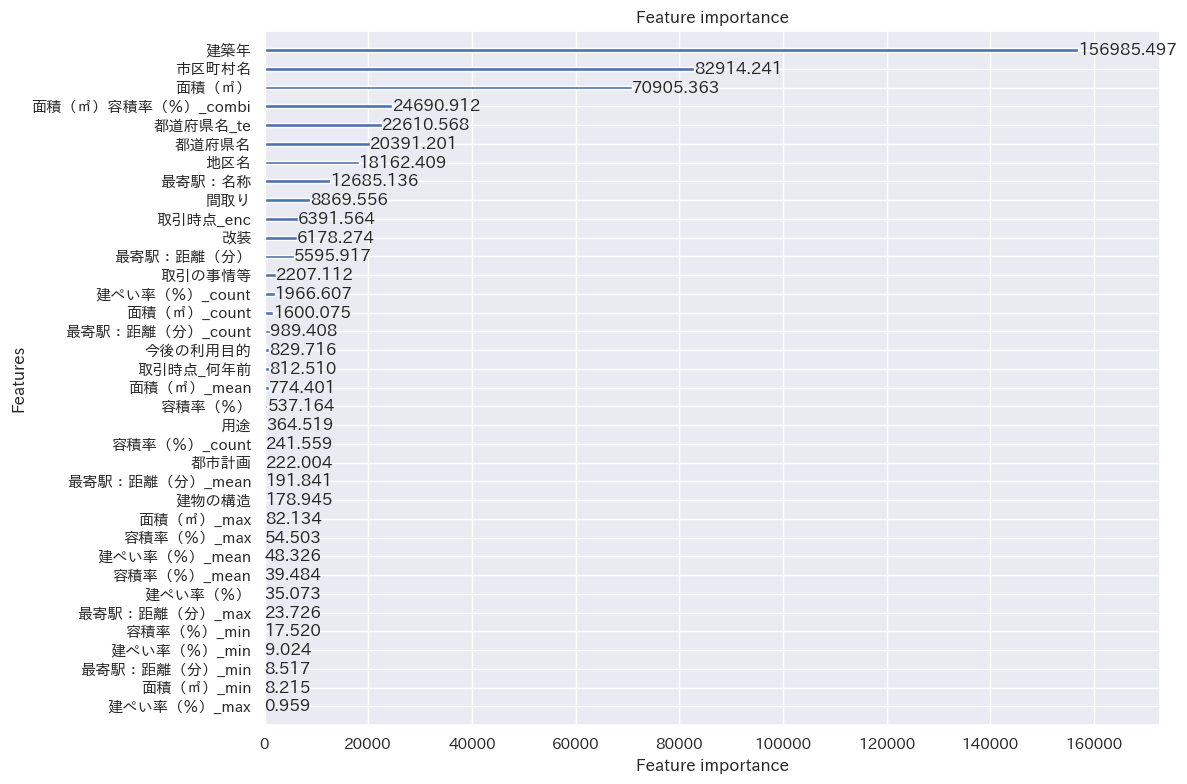

In [ ]:
lgb.plot_importance(model, figsize=(12,8), max_num_features=50, importance_type='gain')
plt.tight_layout()
plt.savefig(BASE_PATH + 'output/feature_importance.png')
plt.show()
plt.close()

## 推論

In [ ]:
test_pred = model.predict(test_x, num_iteration=model.best_iteration)

In [ ]:
test_df[TARGET] = test_pred

<ipython-input-45-c7d24f824a6c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[TARGET] = test_pred


In [ ]:
sub_df = pd.merge(sub_df[['ID']], test_df[['ID', TARGET]], on='ID')
sub_df.to_csv(BASE_PATH + 'output/test_submission.csv', index=False)